<a href="https://colab.research.google.com/github/mateofuertes/kapak_notebooks/blob/first_embeddings/First_Try_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 3 - Text Mining con Kapak Docs


Integrantes: Mateo Fuertes, Kevin Huertas, Jose Contreras

Fecha: 22/09/2024

## Generación de las colecciones de documentos COL1 y COL2/

In [ ]:
import pandas as pd
import os
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta a la carpeta
base_path = '/content/drive/MyDrive/DM_Dataset'

# Cargar las tablas CSV
process_info = pd.read_csv(os.path.join(base_path, 'procesos/process_info.csv'))
preguntas_y_aclaraciones = pd.read_csv(os.path.join(base_path, 'procesos/preguntas_y_aclaraciones.csv'))
sample_files = pd.read_csv(os.path.join(base_path, 'procesos/sample_files.csv'))

print("Tabla de Procesos de Compra (process_info):")
print(process_info.head())

print("\nTabla de Preguntas y Aclaraciones (preguntas_y_aclaraciones):")
print(preguntas_y_aclaraciones.head())

print("\nTabla de Archivos Asociados (sample_files):")
print(sample_files.head())


Tabla de Procesos de Compra (process_info):
   sl_contract_id                                         sd_entidad  \
0         1752147  GOBIERNO AUTONOMO DESCENTRALIZADO MUNICIPAL DE...   
1         1689929  CENTRO CLINICO QUIRURGICO AMBULATORIO HOSPITAL...   
2         1737580  EMPRESA ELÉCTRICA PÚBLICA ESTRATÉGICA CORPORAC...   
3         1699371                         HOSPITAL BÁSICO-ESMERALDAS   
4         1712786  DIRECCION DISTRITAL 09D04 - FEBRES CORDERO - S...   

                                sd_objeto_de_proceso  sie_ic_promedio  
0  ADQUISICION DE UNA MAQUINA EXCAVADORA DE ORUGA...             0.86  
1  ADQUISICIÓN DEL PRIMER REQUERIMIENTO DE FÁRMAC...             0.73  
2         CORP ADQUISICION DE SELLOS DE SEGURIDAD GC             0.63  
3  ADQUISICION DE MEDICAMENTOS CUYO GRUPO TERAPÉU...             0.73  
4  CONTRATACIÓN DEL SERVICIO DE VIGILANCIA Y SEGU...             0.55  

Tabla de Preguntas y Aclaraciones (preguntas_y_aclaraciones):
   sl_contract_id  pregunta_

In [ ]:
# Almacenar los documentos de COL1
col1 = {}

# Recorrer los procesos únicos
for process_id in sample_files['sl_contract_id'].unique():
    files = sample_files[sample_files['sl_contract_id'] == process_id]
    documents = []
    for _, row in files.iterrows():
        file_path = os.path.join(base_path, row['relative_file_path'])
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            documents.append(content)
    col1[process_id] = documents

# Ejemplo
print(f"Número de documentos para el proceso {list(col1.keys())[0]}: {len(col1[list(col1.keys())[0]])}")

Número de documentos para el proceso 1721524: 10


In [ ]:
# Almacenar los documentos de COL2
col2 = {}

# Recorrer los procesos únicos
for process_id in sample_files['sl_contract_id'].unique():
    files = sample_files[sample_files['sl_contract_id'] == process_id]
    # Concatenar todos los documentos
    full_document = ""
    for _, row in files.iterrows():
        file_path = os.path.join(base_path, row['relative_file_path'])
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            full_document += content + "\n"
    col2[process_id] = full_document

# Ejemplo
print(f"Contenido del documento combinado para el proceso {list(col2.keys())[0]}:\n{col2[list(col2.keys())[0]][:500]}...")


Contenido del documento combinado para el proceso 1721524:
TÉRMINOS DE REFERENCIA
SERVICIO DE LOGÍSTICA E IMPLEMENTACIÓN DE MOBILIARIO Y AUDIO
PARA LA ORGANIZACIÓN DE ACTIVIDADES TERRITORIALES
AUSPICIADAS POR EL G.A.D.I. MUNICIPALIDAD DEL CANTÓN DAULE.
1. Antecedentes
El GAD Ilustre Municipalidad del cantón Daule, desde su creación desempeña
un papel de relevancia en la sociedad ecuatoriana, cumpliendo con la política
nacional, con el objetivo de mejorar los índices en la calidad de vida en la
ciudadanía a través de los diferentes programas y proyectos....


In [ ]:
print(f"Número de procesos en COL1: {len(col1)}")
print(f"Número de documentos en COL1: {sum(len(docs) for docs in col1.values())}")

print(f"Número de procesos en COL2: {len(col2)}")
print(f"Número de documentos en COL2: {len(col2)}")


Número de procesos en COL1: 107
Número de documentos en COL1: 828
Número de procesos en COL2: 107
Número de documentos en COL2: 107


## Cálculo de los índices de términos: tf, df, idf, tf-idf

In [ ]:
!pip install nltk spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 21.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
import spacy
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Modelo de lenguaje de spaCy en español
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Preprocesamiento del texto
def preprocess_text(text):
    text = text.lower()

    # Tokenización y lematización con spaCy
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    return ' '.join(tokens)

# Aplicar en COL1 y COL2
col1_preprocessed = {key: [preprocess_text(doc) for doc in docs] for key, docs in col1.items()}
col2_preprocessed = {key: preprocess_text(doc) for key, doc in col2.items()}


In [ ]:
# Índices de términos para COL1
tf_col1 = {}
for process_id, docs in col1_preprocessed.items():
    tf_process = []
    for doc in docs:
        tf_process.append(Counter(doc.split()))
    tf_col1[process_id] = tf_process

df_col1 = Counter()
for docs in col1_preprocessed.values():
    unique_terms = set()
    for doc in docs:
        unique_terms.update(doc.split())
    df_col1.update(unique_terms)

total_documents = sum(len(docs) for docs in col1_preprocessed.values())
idf_col1 = {term: np.log(total_documents / (df + 1)) for term, df in df_col1.items()}

tf_idf_col1 = {}
for process_id, tf_docs in tf_col1.items():
    tf_idf_process = []
    for tf_doc in tf_docs:
        tf_idf_doc = {term: tf * idf_col1.get(term, 0) for term, tf in tf_doc.items()}
        tf_idf_process.append(tf_idf_doc)
    tf_idf_col1[process_id] = tf_idf_process

# Ejemplos de tf-idf para 15 términos
sample_terms = list(idf_col1.keys())[:15]
print(f"tf-idf para algunos términos en COL1:")
for term in sample_terms:
    print(f"{term}: {[doc.get(term, 0) for process_docs in tf_idf_col1.values() for doc in process_docs]}")


tf-idf para algunos términos en COL1:
resumen: [6.703434648797572, 0, 0, 0, 0, 0, 0, 0, 0, 13.406869297595144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.703434648797572, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.703434648797572, 0, 3.351717324398786, 3.351717324398786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.351717324398786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.351717324398786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.703434648797572, 3.351717324398786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.351717324398786, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
documents_col2 = list(col2_preprocessed.values())

vectorizer = TfidfVectorizer()
tfidf_matrix_col2 = vectorizer.fit_transform(documents_col2)

# Extraer los términos del vocabulario
terms = vectorizer.get_feature_names_out()
sample_terms = terms[:15]

# tf-idf para 15 términos en COL2
print(f"tf-idf para algunos términos en COL2:")
for idx, term in enumerate(sample_terms):
    print(f"{term}: {tfidf_matrix_col2[:, idx].toarray().flatten()}")


tf-idf para algunos términos en COL2:
aa: [0.         0.         0.         0.         0.         0.00095433
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.0039491  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.0021704  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.   

## Relevancia de documentos basado en similaridad del coseno en COL1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Modelo de español de spaCy
import spacy
nlp = spacy.load("es_core_news_sm")


In [ ]:
def cosine_similarity_query(query, documents):
    vectorizer = TfidfVectorizer()
    all_docs = [query] + documents
    tfidf_matrix = vectorizer.fit_transform(all_docs)

    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    return cosine_sim


In [ ]:
# Proceso de compra de ejemplo
process_id_example = 1752147

# Query de ejemplo
query_example = "servicios de logística para transporte"

# Obtener los documentos preprocesados del proceso específico
docs_process = col1_preprocessed.get(process_id_example, [])

# Calcular la similitud del coseno para la query y los documentos del proceso
cosine_scores = cosine_similarity_query(query_example, docs_process)
ranking = sorted(enumerate(cosine_scores), key=lambda x: x[1], reverse=True)

# Mostrar el ranking de documentos
print(f"Ranking de documentos para el proceso {process_id_example} basado en la query '{query_example}':")
for rank, (index, score) in enumerate(ranking):
    print(f"Documento {index + 1} - Similitud: {score:.4f}")


Ranking de documentos para el proceso 1752147 basado en la query 'servicios de logística para transporte':
Documento 8 - Similitud: 0.0024
Documento 1 - Similitud: 0.0000
Documento 2 - Similitud: 0.0000
Documento 3 - Similitud: 0.0000
Documento 4 - Similitud: 0.0000
Documento 5 - Similitud: 0.0000
Documento 6 - Similitud: 0.0000
Documento 7 - Similitud: 0.0000


In [ ]:
# Concatenar preguntas y respuestas para un proceso dado
def get_combined_questions_answers(process_id):
    qa_process = preguntas_y_aclaraciones[preguntas_y_aclaraciones['sl_contract_id'] == process_id]
    combined_text = " ".join(qa_process['pregunta_aclaracion'].fillna("") + " " + qa_process['respuesta_aclaracion'].fillna(""))
    return preprocess_text(combined_text)

qa_vector = get_combined_questions_answers(process_id_example)
print(f"Vector de preguntas y respuestas del proceso {process_id_example}: {qa_vector[:200]}...")


Vector de preguntas y respuestas del proceso 12345: ...


In [ ]:
# Calcular la similitud del coseno para el vector de preguntas y respuestas y los documentos del proceso
cosine_scores_qa = cosine_similarity_query(qa_vector, docs_process)
ranking_qa = sorted(enumerate(cosine_scores_qa), key=lambda x: x[1], reverse=True)

# Mostrar el ranking de documentos
print(f"Ranking de documentos para el proceso {process_id_example} basado en preguntas y respuestas:")
for rank, (index, score) in enumerate(ranking_qa):
    print(f"Documento {index + 1} - Similitud: {score:.4f}")


Ranking de documentos para el proceso 1752147 basado en preguntas y respuestas:
Documento 1 - Similitud: 0.0000
Documento 2 - Similitud: 0.0000
Documento 3 - Similitud: 0.0000
Documento 4 - Similitud: 0.0000
Documento 5 - Similitud: 0.0000
Documento 6 - Similitud: 0.0000
Documento 7 - Similitud: 0.0000
Documento 8 - Similitud: 0.0000


In [ ]:
def rank_documents_by_query(process_id, query):
    docs_process = col1_preprocessed.get(process_id, [])
    if not docs_process:
        print(f"No se encontraron documentos para el proceso {process_id}.")
        return

    # Calcular la similitud del coseno para la query y los documentos del proceso
    cosine_scores = cosine_similarity_query(query, docs_process)
    ranking = sorted(enumerate(cosine_scores), key=lambda x: x[1], reverse=True)

    # Mostrar el ranking
    print(f"Ranking de documentos para el proceso {process_id} basado en la query '{query}':")
    for rank, (index, score) in enumerate(ranking):
        print(f"Documento {index + 1} - Similitud: {score:.4f}")

def rank_documents_by_qa(process_id):
    docs_process = col1_preprocessed.get(process_id, [])
    if not docs_process:
        print(f"No se encontraron documentos para el proceso {process_id}.")
        return

    # Obtener el vector de preguntas y respuestas para el proceso
    qa_vector = get_combined_questions_answers(process_id)
    if not qa_vector:
        print(f"No se encontraron preguntas y respuestas para el proceso {process_id}.")
        return

    # Calcular la similitud del coseno para el vector de preguntas y respuestas y los documentos del proceso
    cosine_scores_qa = cosine_similarity_query(qa_vector, docs_process)
    ranking_qa = sorted(enumerate(cosine_scores_qa), key=lambda x: x[1], reverse=True)

    # Mostrar el ranking
    print(f"Ranking de documentos para el proceso {process_id} basado en preguntas y respuestas:")
    for rank, (index, score) in enumerate(ranking_qa):
        print(f"Documento {index + 1} - Similitud: {score:.4f}")

# Ejemplo
process_id_example = 1752147
query_example = "maquina escavadora de orugas"

# Ranking por query
rank_documents_by_query(process_id_example, query_example)

# Ranking por preguntas y respuestas
rank_documents_by_qa(process_id_example)


Ranking de documentos para el proceso 1752147 basado en la query 'maquina escavadora de orugas':
Documento 1 - Similitud: 0.0000
Documento 2 - Similitud: 0.0000
Documento 3 - Similitud: 0.0000
Documento 4 - Similitud: 0.0000
Documento 5 - Similitud: 0.0000
Documento 6 - Similitud: 0.0000
Documento 7 - Similitud: 0.0000
Documento 8 - Similitud: 0.0000
Ranking de documentos para el proceso 1752147 basado en preguntas y respuestas:
Documento 1 - Similitud: 0.1316
Documento 2 - Similitud: 0.1108
Documento 8 - Similitud: 0.0685
Documento 5 - Similitud: 0.0399
Documento 4 - Similitud: 0.0229
Documento 6 - Similitud: 0.0124
Documento 3 - Similitud: 0.0076
Documento 7 - Similitud: 0.0059


## Análisis de procesos de alto riesgo basado en la similaridad del coseno en COL2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Cargar la tabla process_info
base_path = '/content/drive/MyDrive/DM_Dataset'
process_info = pd.read_csv(os.path.join(base_path, 'procesos/process_info.csv'))

# Filtrar procesos de alto riesgo (sie_ic_promedio > 0.5)
high_risk_processes = process_info[process_info['sie_ic_promedio'] > 0.5]
print(f"Procesos de alto riesgo (sie_ic_promedio > 0.5):\n{high_risk_processes[['sl_contract_id', 'sie_ic_promedio']].head()}")

# Seleccionar un proceso de alto riesgo
selected_process_id = high_risk_processes.iloc[0]['sl_contract_id']
selected_process_risk = high_risk_processes.iloc[0]['sie_ic_promedio']
print(f"Proceso seleccionado: ID = {selected_process_id}, Riesgo = {selected_process_risk}")


Procesos de alto riesgo (sie_ic_promedio > 0.5):
   sl_contract_id  sie_ic_promedio
0         1752147             0.86
1         1689929             0.73
2         1737580             0.63
3         1699371             0.73
4         1712786             0.55
Proceso seleccionado: ID = 1752147, Riesgo = 0.86


In [ ]:
# Vectorizador TF-IDF para COL2
vectorizer = TfidfVectorizer()
tfidf_matrix_col2 = vectorizer.fit_transform(col2_preprocessed.values())

# Obtener el vector del documento del proceso seleccionado
selected_process_vector = vectorizer.transform([col2_preprocessed[selected_process_id]])

# Calcular la similitud del coseno entre el proceso seleccionado y todos los documentos en COL2
cosine_similarities = cosine_similarity(selected_process_vector, tfidf_matrix_col2).flatten()

# Resultados
cosine_df = pd.DataFrame({
    'sl_contract_id': col2_preprocessed.keys(),
    'cosine_similarity': cosine_similarities,
    'sie_ic_promedio': [process_info.set_index('sl_contract_id').loc[pid, 'sie_ic_promedio'] for pid in col2_preprocessed.keys()]
})

# Ranking descendente basado en similaridad del coseno
cosine_df_sorted = cosine_df.sort_values(by='cosine_similarity', ascending=False)
print(f"Ranking de documentos basado en la similaridad del coseno:\n{cosine_df_sorted.head(10)}")


Ranking de documentos basado en la similaridad del coseno:
     sl_contract_id  cosine_similarity  sie_ic_promedio
101         1752147           1.000000             0.86
24          1742137           0.970454             0.88
41          1756064           0.970454             0.40
105         1685410           0.968444             0.73
1           1699371           0.966849             0.73
65          1702911           0.965723             0.86
47          1743301           0.965299             0.86
94          1723420           0.963729             0.43
19          1682777           0.961776             0.64
22          1737426           0.957826             0.75


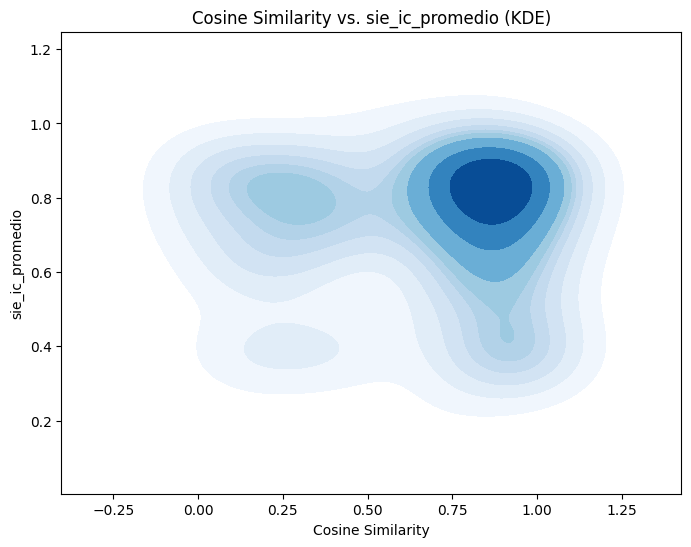

In [ ]:
# Gráfico KDE de Similaridad del Coseno vs. sie_ic_promedio
plt.figure(figsize=(8, 6))
sns.kdeplot(data=cosine_df, x='cosine_similarity', y='sie_ic_promedio', cmap="Blues", fill=True)
plt.title("Cosine Similarity vs. sie_ic_promedio (KDE)")
plt.xlabel("Cosine Similarity")
plt.ylabel("sie_ic_promedio")
plt.show()


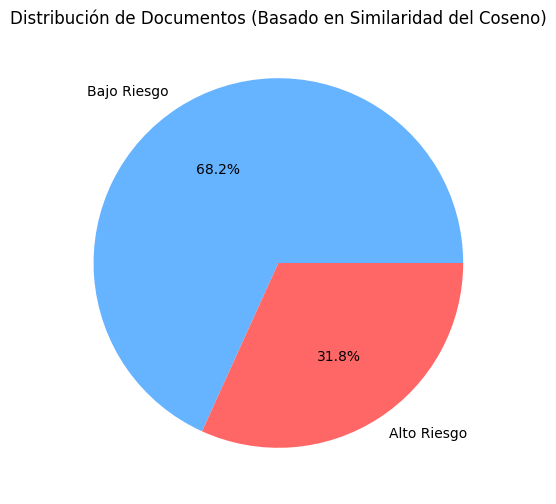

In [ ]:
# Umbral de riesgo basado en similaridad del coseno (>0.5)
cosine_df['high_risk_cosine'] = cosine_df['cosine_similarity'] > 0.5

# Gráfico de pastel para similaridad del coseno
cosine_risk_counts = cosine_df['high_risk_cosine'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(cosine_risk_counts, labels=['Bajo Riesgo', 'Alto Riesgo'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'])
plt.title("Distribución de Documentos (Basado en Similaridad del Coseno)")
plt.show()


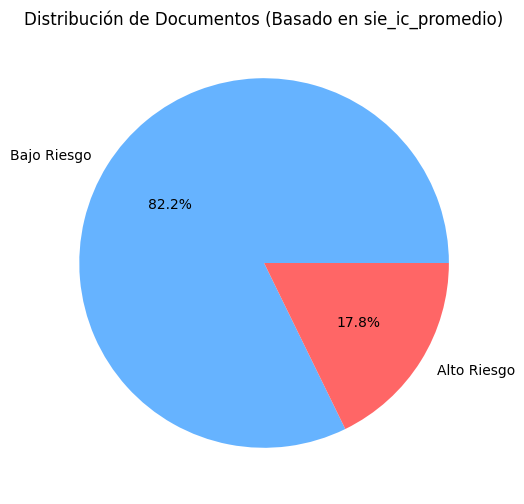

In [ ]:
# Umbral de riesgo basado en sie_ic_promedio (>0.5)
cosine_df['high_risk_real'] = cosine_df['sie_ic_promedio'] > 0.5

# Gráfico de pastel para sie_ic_promedio
real_risk_counts = cosine_df['high_risk_real'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(real_risk_counts, labels=['Bajo Riesgo', 'Alto Riesgo'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'])
plt.title("Distribución de Documentos (Basado en sie_ic_promedio)")
plt.show()


## Similaridad de todos contra todos en COL2,

In [ ]:
vectorizer_col2 = TfidfVectorizer()
tfidf_matrix_col2 = vectorizer_col2.fit_transform(col2_preprocessed.values())

# Calcular la matriz de similitud del coseno para todos los documentos en COL2
cosine_similarity_matrix = cosine_similarity(tfidf_matrix_col2)
print(f"Matriz de Similaridad [n x n]:\n{cosine_similarity_matrix}")

Matriz de Similaridad [n x n]:
[[1.         0.90014591 0.86304295 ... 0.69229901 0.89778431 0.04732227]
 [0.90014591 1.         0.94949423 ... 0.70389558 0.9967199  0.04048896]
 [0.86304295 0.94949423 1.         ... 0.68295596 0.95205573 0.04111847]
 ...
 [0.69229901 0.70389558 0.68295596 ... 1.         0.70187017 0.04830408]
 [0.89778431 0.9967199  0.95205573 ... 0.70187017 1.         0.04001541]
 [0.04732227 0.04048896 0.04111847 ... 0.04830408 0.04001541 1.        ]]


In [ ]:
# Calcular la similaridad promedio para cada documento
average_similarity_vector = cosine_similarity_matrix.mean(axis=1)

# Resultados
similarity_df = pd.DataFrame({
    'sl_contract_id': col2_preprocessed.keys(),
    'average_similarity': average_similarity_vector
})

print(f"Similaridad promedio por documento:\n{similarity_df.head(10)}")

Similaridad promedio por documento:
   sl_contract_id  average_similarity
0         1721524            0.619843
1         1699371            0.665271
2         1745524            0.643111
3         1758687            0.632904
4         1704225            0.624177
5         1747722            0.287654
6         1686226            0.591832
7         1709477            0.284812
8         1755826            0.573848
9         1728041            0.283921


In [ ]:
# Umbral de atipicidad
threshold = similarity_df['average_similarity'].quantile(0.25)

# Filtrar documentos atípicos
outliers = similarity_df[similarity_df['average_similarity'] < threshold]
print(f"Documentos Atípicos (similaridad promedio < {threshold:.4f}):\n{outliers}")

Documentos Atípicos (similaridad promedio < 0.2890):
     sl_contract_id  average_similarity
5           1747722            0.287654
7           1709477            0.284812
9           1728041            0.283921
11          1743489            0.043523
12          1709875            0.195805
13          1706638            0.194466
25          1691658            0.132485
32          1729960            0.224256
33          1705469            0.165395
36          1722530            0.248445
39          1731467            0.036498
40          1700190            0.205299
45          1699086            0.075371
49          1735450            0.145933
51          1729307            0.096040
53          1710924            0.088068
56          1708570            0.142131
57          1725258            0.262893
68          1703008            0.125253
73          1728315            0.253356
76          1742281            0.060860
78          1716157            0.199545
79          1739662        

In [ ]:
outliers_info = outliers.merge(process_info, on='sl_contract_id', how='left')
print(f"Información de Documentos Atípicos:\n{outliers_info[['sl_contract_id', 'average_similarity', 'sie_ic_promedio', 'sd_objeto_de_proceso']].head()}")

Información de Documentos Atípicos:
   sl_contract_id  average_similarity  sie_ic_promedio  \
0         1747722            0.287654             0.86   
1         1709477            0.284812             0.38   
2         1728041            0.283921             0.86   
3         1743489            0.043523             0.71   
4         1709875            0.195805             0.82   

                                sd_objeto_de_proceso  
0  ADQUISICIÓN Y MONTAJE DE COMPUERTAS DESLIZANTE...  
1  ADQUIRIR IMPLEMENTOS DE ORDEÑO PARA EL GADM- E...  
2  ADQUISICIÓN DE DISPOSITIVOS MÉDICOS (REACTIVOS...  
3  Adquisición e instalación de juegos infantiles...  
4  PROVISION DEL SERVICIO DE SEGURIDAD Y VIGILANC...  


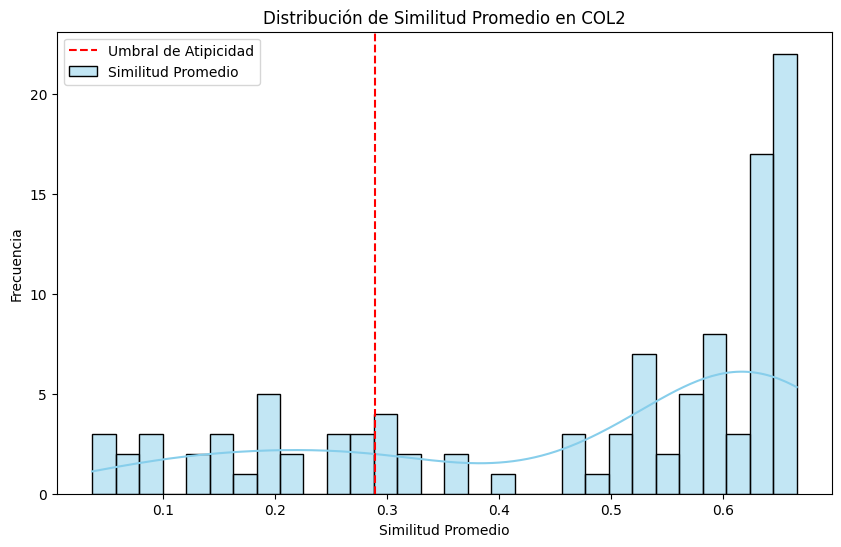

In [ ]:
# Histograma de distribución de similitud promedio
plt.figure(figsize=(10, 6))
sns.histplot(similarity_df['average_similarity'], bins=30, kde=True, color='skyblue', label='Similitud Promedio')
plt.axvline(threshold, color='red', linestyle='--', label='Umbral de Atipicidad')
plt.title("Distribución de Similitud Promedio en COL2")
plt.xlabel("Similitud Promedio")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()


La similitud promedio de los documentos en COL2 tiene una distribución que parece bimodal: hay picos significativos tanto en el lado izquierdo (similitud baja) como en el derecho (similitud alta) del gráfico. Esto sugiere que hay dos grupos principales de documentos: unos que son más atípicos (con baja similitud) y otros que son más comunes (con alta similitud).

Documentos Atípicos:

Los documentos que se encuentran a la izquierda del umbral de atipicidad (menor a 0.3) son considerados documentos atípicos. Estos documentos tienen baja similitud con el resto de la colección, lo que sugiere que sus contenidos son únicos o distintos en comparación con otros documentos de COL2.
Estos documentos podrían corresponder a compras con descripciones inusuales o especificaciones muy particulares, lo cual podría indicar procesos de compra poco comunes o, en algunos casos, potencialmente sospechosos.
Documentos Comunes:

A la derecha del umbral (mayor a 0.3), especialmente a partir de 0.5, la similitud promedio aumenta considerablemente. Los documentos en esta región son más comunes, es decir, tienen un contenido similar a muchos otros documentos en la colección. Esto podría indicar que estos procesos de compra siguen patrones o descripciones estandarizadas.
Identificación de Patrones:

El pico más alto en la similitud promedio alrededor de 0.6 sugiere que hay un grupo de documentos que son muy similares entre sí, posiblemente describiendo procesos de compra que son muy homogéneos o estandarizados.
Conclusión
Documentos Atípicos (Similitud Baja): Estos documentos deben ser revisados para entender por qué difieren del resto. Podrían representar compras no comunes o tener características que los hacen destacar.
Documentos Comunes (Similitud Alta): Representan la mayoría de los procesos de compra que siguen un patrón conocido y estandarizado.